# Disaster Tweets – Final Project

This project uses data from the Kaggle competition **“Natural Language Processing with Disaster Tweets.”**  
The goal is to build a simple machine learning model that predicts whether a tweet is about a **real disaster (1)** or **not (0).**  

I used Python with **pandas, scikit-learn, and matplotlib**.  
Steps included: 
 - loading the data,
 - cleaning the text,
 - exploring with one bar chart,
 - training a **TF-IDF + Logistic Regression** model,
 - checking the F1 score.

In [28]:
# Imports

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, pandas as pd

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Finding the input folder 
INPUT_DIR = '/kaggle/input/nlp-getting-started' if os.path.exists('/kaggle') else '.'
print('Using data folder:', INPUT_DIR)


Using data folder: /kaggle/input/nlp-getting-started


In [29]:
# Load data

KAGGLE_DIR = '/kaggle/input/nlp-getting-started'
COLAB_DIR  = '/content/nlp-getting-started'
LOCAL_DIR  = './nlp-getting-started'

if os.path.exists(KAGGLE_DIR):
    INPUT_DIR = KAGGLE_DIR
elif os.path.exists(COLAB_DIR):
    INPUT_DIR = COLAB_DIR
elif os.path.exists(os.path.join(LOCAL_DIR, 'train.csv')):
    INPUT_DIR = LOCAL_DIR
elif all(os.path.exists(p) for p in ['train.csv','test.csv','sample_submission.csv']):
    INPUT_DIR = '.'
else:
    m = glob.glob('**/train.csv', recursive=True)
    assert m, "Couldn't find train.csv. Put the three CSVs in this folder or set INPUT_DIR."
    INPUT_DIR = os.path.dirname(m[0])

print('Using data folder:', INPUT_DIR)

train  = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test   = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
sample = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df = train

print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.head()

Using data folder: /kaggle/input/nlp-getting-started
Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Counts by class (0=not disaster, 1=disaster):
target
0    4342
1    3271
Name: count, dtype: int64


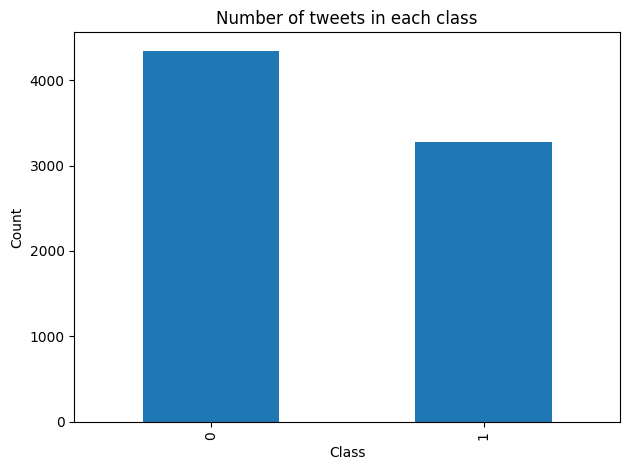

In [30]:
# Look at the data and make a graph

# Count how many examples are class 0 and class 1.
counts = train['target'].value_counts().sort_index()
print('Counts by class (0=not disaster, 1=disaster):')
print(counts)

# A bar chart
plt.figure()
counts.plot(kind='bar')
plt.title('Number of tweets in each class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

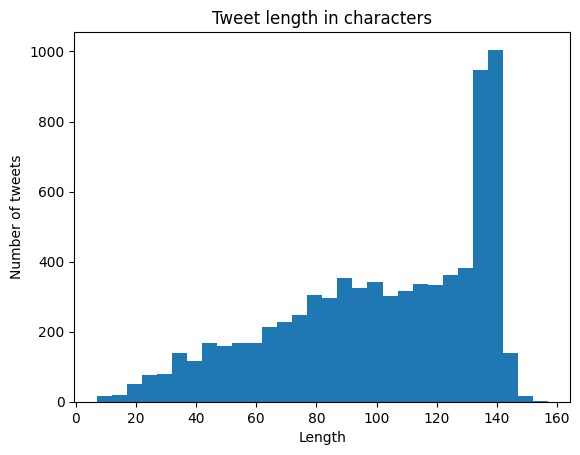

In [31]:
# Tweet length histogram

train['text_len'] = train['text'].str.len()
plt.figure()
plt.hist(train['text_len'], bins=30)
plt.title('Tweet length in characters')
plt.xlabel('Length')
plt.ylabel('Number of tweets')
plt.show()

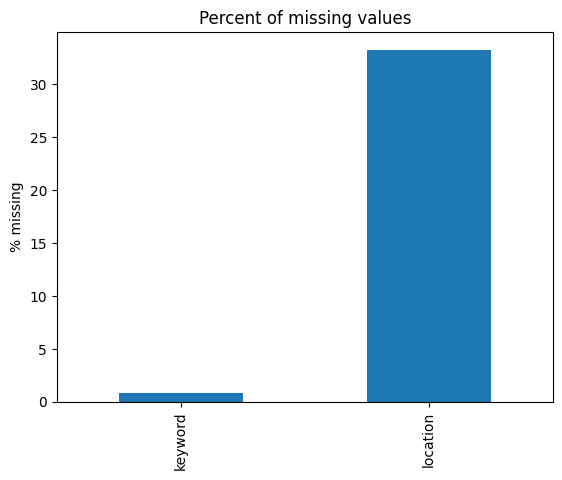

In [32]:
# Missing keyword/location

missing = train[['keyword','location']].isna().mean() * 100
missing.plot(kind='bar')
plt.title('Percent of missing values')
plt.ylabel('% missing')
plt.show()

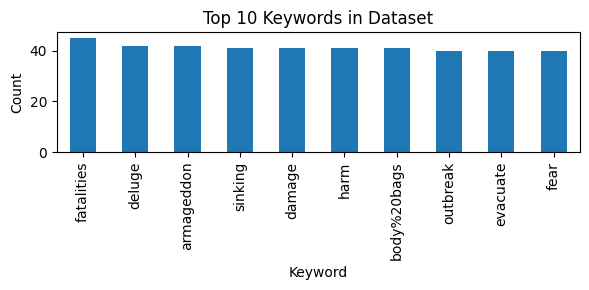

In [33]:
# Top 10 Keywords

top_keywords = df['keyword'].dropna().value_counts().head(10)

plt.figure(figsize=(6,3))
top_keywords.plot(kind='bar')
plt.title('Top 10 Keywords in Dataset')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


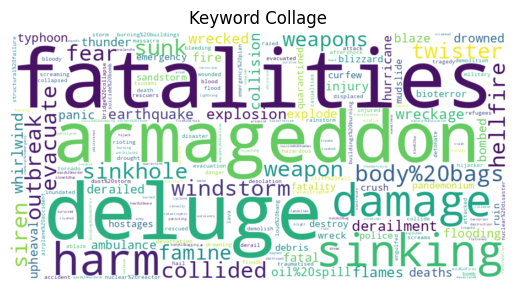

In [34]:
# Collage

freq = df['keyword'].dropna().value_counts().to_dict()
wc_kw = WordCloud(width=900, height=450, background_color="white")
img_kw = wc_kw.generate_from_frequencies(freq)

plt.imshow(img_kw, interpolation="bilinear")
plt.axis("off")
plt.title("Keyword Collage")
plt.show()

In [35]:
# Clean up the text

# Make a function to clean each tweet.
# That is
# - make text lower case
# - remove links
# - remove @user names
# - remove the # sign (keep the word)

url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@[A-Za-z0-9_]+')

def clean_text(s):
    if not isinstance(s, str):
        return ''
    s = s.lower()
    s = url_re.sub(' ', s)
    s = mention_re.sub(' ', s)
    s = s.replace('#', ' ')
    s = ' '.join(s.split())
    return s

# Combine keyword and text to form a string to learn from
def make_input(df):
    kw = df['keyword'].fillna('').str.replace('%20', ' ', regex=False)
    tx = df['text'].fillna('')
    return (kw + ' ' + tx).apply(clean_text)

X_all = make_input(train)
y_all = train['target'].values
X_test = make_input(test)

print('Example cleaned tweets:')
print(X_all.head().tolist()[:3])

Example cleaned tweets:
['our deeds are the reason of this earthquake may allah forgive us all', 'forest fire near la ronge sask. canada', "all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected"]


In [36]:
# Build a simple model (TF-IDF + Logistic Regression)

# TF-IDF turns text into numbers. Logistic Regression is a classifier.

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
clf = LogisticRegression(max_iter=200, class_weight='balanced', C=2.0)


# Test the model on a hold-out set with F1 score
X_tr, X_va, y_tr, y_va = train_test_split(X_all, y_all, test_size=0.2,
                                          stratify=y_all, random_state=RANDOM_STATE)

# Fit on the training split
X_tr_t = tfidf.fit_transform(X_tr)
clf.fit(X_tr_t, y_tr)

# Predict on the validation split
X_va_t = tfidf.transform(X_va)
va_pred = clf.predict(X_va_t)
f1 = f1_score(y_va, va_pred)
print('Validation F1:', round(f1, 4))

Validation F1: 0.7695


In [37]:
# Train on all data and create submission.csv

X_all_t = tfidf.fit_transform(X_all)
clf.fit(X_all_t, y_all)

X_test_t = tfidf.transform(X_test)
test_pred = clf.predict(X_test_t)

submission = pd.DataFrame({'id': test['id'], 'target': test_pred})
submission.to_csv('submission.csv', index=False)
print('Saved: submission.csv')
submission.head()


Saved: submission.csv


,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
